# In the Name of Allah

Name: `Mohammad Taslimi`

Std. Number: `99101321`

The goal of this notebook is to implement JbDA attack and assess its performance against a pretrained model. In the first stage, you are going to load the MNIST dataset and a the weights of a model trained on this dataset. Afterwards, you must try to generate adversarial examples using FGSM. Finally, you will implement JbDA and compare the new blackbox attack's performance with FGSM.

There are some questions in the middle of the notebook. Make sure not to overlook them!

# Preparations

In [124]:
# Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
!cd '/content/drive/MyDrive/SPML_HW4'  #replace the location with your desired location.

In [126]:
# Import neccesary libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset
import os
import random
from model import Net

In [127]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)

cuda


In [128]:
#preparing MNIST train and test dataloader. It is easier to use the MNIST dataset in torchvision package.

batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [129]:
#loading the model
model = Net()
model.load_state_dict(torch.load("/content/drive/MyDrive/SPML_HW4/model.pth", map_location=torch.device(device)))

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

In [130]:
#simple test function that returns accuracy of net on data
def test (net, loader):
  net.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = net(inputs)
      _, preds = outputs.max(1)

      total += inputs.shape[0]
      correct += preds.eq(labels).sum().item()

    return correct/total*100

In [131]:
print ("Accuracy of the model on train set is: {}%".format(test(model, trainloader)))
print ("Accuracy of the model on test set is: {}%".format(test(model, testloader)))

Accuracy of the model on train set is: 92.87833333333333%
Accuracy of the model on test set is: 92.93%


# FGSM Attack

In [132]:
#FGSM function (smiliar to what you have implemented before)
def FGSM (model, x, y, epsilon):
    model.zero_grad()
    x = x.detach()
    x.requires_grad=True
    loss = criterion(model(x), y)
    loss.backward(retain_graph=True)
    delta = x.grad.detach().sign()*epsilon
    return x+delta, delta, model(x+delta)



For $\epsilon\in [\frac{4}{255}, \frac{8}{255}, \frac{16}{255}, \frac{32}{255}, \frac{64}{255}, \frac{128}{255}]$, compute the model's accuracy on FGSM adversarial test samples.
Plot accuracy vs. $\epsilon$. What do you see? Justify your observation.

`answer`: As observed in the plot of accuracy versus $\epsilon$, the Fast Gradient Sign Method (FGSM) attack does not significantly impact the base model's performance. Upon inspecting the adversarial examples, it was found that they were nearly identical to the input images. Specifically, on average, 120 out of 128 images in each batch remained unchanged. This observation suggests that the gradient does not propagate back effectively, thereby limiting the success of the FGSM attack.


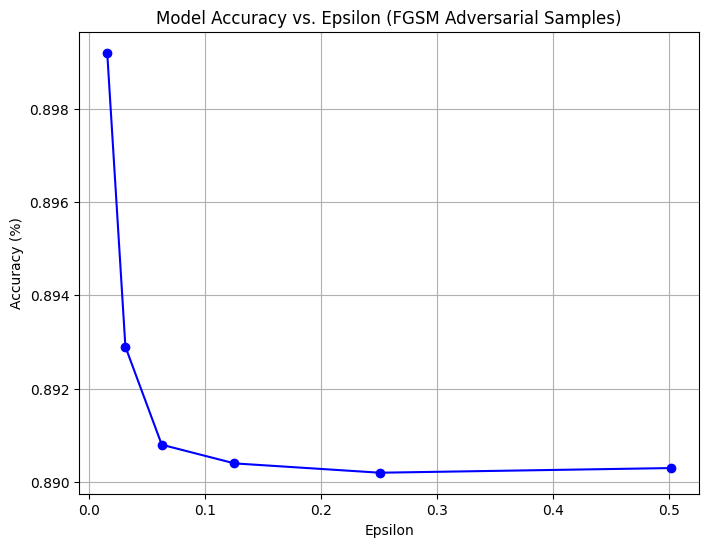

[0.8992, 0.8929, 0.8908, 0.8904, 0.8902, 0.8903]

In [156]:
def FGSM_attack(base_model, substitute_model, epsilons, testloader):
    '''
    This function generates adversarial examples using the Fast Gradient Sign Method (FGSM) attack
    with a substitute model and transfers them to the base model. It then evaluates the accuracy
    of this black-box attack on the base model.

    Inputs:
    base_model: The base model that is the target of the attack.
    substitute_model: The model used to generate adversarial examples.
    epsilons: A list of epsilon values used in the FGSM attack.
    testloader: The dataloader from which adversarial examples are generated.

    Outputs:
    accuracies: The accuracies of the base model when tested against the adversarial examples.
    '''
    accuracies = []
    for epsilon in epsilons:
        total = 0
        correct = 0
        for inputs, labels in testloader:
            base_model.eval()
            substitute_model.eval()
            inputs, labels = inputs.to(device), labels.to(device)
            adversarial_outputs, _, _ = FGSM(substitute_model, inputs, labels, epsilon)
            outputs = base_model(adversarial_outputs)
            _, preds = outputs.max(1)
            total += inputs.shape[0]
            correct += preds.eq(labels).sum().item()

        accuracy = correct/total
        accuracies.append(accuracy)

    # Plot accuracy vs. epsilon
    plt.figure(figsize=(8, 6))
    plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy vs. Epsilon (FGSM Adversarial Samples)')
    plt.grid(True)
    plt.show()


    return accuracies



epsilons = [4/255, 8/255, 16/255, 32/255, 64/255, 128/255]
FGSM_attack(model, model, epsilons, testloader)


# JbDA
Select 150 initial random sample from the test set, then train a new model using JbDA. Finally, generate adversarial examples using the newly-trained model.
    

In [134]:
def train(epoch, model, optimizer, trainloader, criterion):

    '''
    This function trains a given model for a specified number of epochs using a provided optimizer and criterion.
    It computes the loss and updates the model parameters accordingly. It also calculates the training accuracy
    and prints the loss and accuracy statistics for each epoch.

    Inputs:
    epoch: The number of epochs for which the model is to be trained.
    model: The model to be trained.
    optimizer: The optimizer used to update the model parameters.
    trainloader: The dataloader providing the training data.
    criterion: The criterion used to calculate the loss.

    Outputs:
    average_loss: The average loss over the training data for the current epoch.
    train_accuracy: The accuracy of the model on the training data for the current epoch.
    '''

    correct = 0
    total = 0
    print(f'Epoch {epoch+1}:')
    model.train()
    running_loss = 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute loss and update parameters
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Compute train accuracy
        _, predictions = outputs.max(1)
        total += inputs.shape[0]
        correct += predictions.eq(targets).sum().item()



    # Print statistics
    average_loss = running_loss/len(trainloader)
    train_accuracy = 100. * (correct/total)
    print(f'Train Loss: {average_loss}, Train Accuracy: {train_accuracy}%')

    return average_loss, train_accuracy



class AugmentedMNIST(Dataset):

    '''
    This class is a custom dataset for the MNIST data. It allows for additional transformations to be applied to the inputs and targets.

    Inputs:
    inputs: The input data.
    targets: The target data.
    transform: Optional transformation to be applied on the input data.
    target_transform: Optional transformation to be applied on the target data.
    '''


    def __init__(self, inputs, targets, transform=None, target_transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        image = self.inputs[idx]
        target = self.targets[idx]
        if self.transform:
            image = image/255


        return image.unsqueeze(dim=0), target


def select_random_samples(dataset, num_sample=150):


    '''
    This function selects a specified number of random samples from a given dataset.

    Inputs:
    dataset: The dataset from which the samples are to be selected.
    num_sample: The number of samples to be selected.

    Outputs:
    random_samples: The randomly selected samples from the dataset.
    random_targets: The targets corresponding to the randomly selected samples.
    '''
    # select random indecies
    total_samples = len(dataset)
    random_indecies = torch.randperm(total_samples)[:num_sample]
    # select random samples using random indecies
    random_samples = dataset.data[random_indecies]
    random_targets = dataset.targets[random_indecies]

    return random_samples, random_targets



In [148]:
def augment(inputs, substitute_model, base_model, update_coef):
  '''
  The goal of this function is to create jacobian-based augmented data and return them.

  inputs: A tensor containing the input data that is going to be augmented.
  substitute_model: The substitute model you are training with JBDA.
  base_model: The initial model which you want to attack.
  update_coeff: augmentation coefficient (lambda)
  '''
  augmented_data = None
  augmented_labels = None
  base_model.eval()
  for images, _ in inputs:
      images = images.to(device)
      # Labeling data with base model
      _, labels = base_model(images).max(1)
      # Generating adversarial examples for substitute model with labels generated using base model
      adversarial_images, _, adversarial_labels = FGSM(substitute_model, images, labels, update_coef)
      _, adversarial_labels = adversarial_labels.max(1)

      # Adding the adversarial samples to augmented dataset
      if augmented_data is None:
         augmented_data = torch.cat([images, adversarial_images], dim=0)
         augmented_labels = torch.cat([labels, adversarial_labels], dim=0)
      else:
         augmented_data = torch.cat([augmented_data, images, adversarial_images], dim=0)
         augmented_labels = torch.cat([augmented_labels, labels, adversarial_labels], dim=0)

  return augmented_data.squeeze(dim=1), augmented_labels


def train_jacobian(base_model, dataloader, epochs, rounds, batch_size=50, update_coef=0.1):
  '''
  The goal of this function is to train and return a new model with JbDA.

  base_model: The initial model which you want to attack.
  dataloader: The dataloader containing the initial samples
  epochs: The number of epochs you want to train the model in each round
  rounds: max_rho
  update_coeff: augmentation coefficient (lambda)
  '''


  rounds_accuracies = []
  rounds_average_loss = []

  for round in range(rounds):

      print(f'round: {round}-----------------------------------------------------------------------------')
      # Train a model from scratch at each round
      substitute_model = Net()
      substitute_model.to(device)
      optimizer = optim.Adam(substitute_model.parameters(), lr=0.001)
      # Training loop
      for epoch in range(epochs):
          average_loss, train_accuracy = train(epoch, substitute_model, optimizer, dataloader, criterion)
          print(f'Test accuracy at epoch {epoch+1}: {test(substitute_model, testloader)}\n\n')

      # storing statistics
      rounds_accuracies.append(train_accuracy)
      rounds_average_loss.append(average_loss)
      # Augmenting Dataset
      augmented_data, augmented_labels = augment(dataloader, substitute_model, base_model, update_coef)
      augmented_dataset = AugmentedMNIST(augmented_data, augmented_labels)
      dataloader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)


  return substitute_model, rounds_average_loss, rounds_accuracies

In [157]:
# Preparing initial dataset
initial_inputs, initial_targets = select_random_samples(testset, num_sample=150)
initial_trainset = AugmentedMNIST(inputs=initial_inputs, targets=initial_targets,
                                  transform=testset.transform)
initial_trainloader = DataLoader(initial_trainset, batch_size=batch_size, shuffle=True)


# setting hyperparameters and training the substitute model
rounds_accuracies = []
rounds_average_loss = []
epochs = 15
rounds = 5
update_coef = 0.1
model.to(device)
new_model, rounds_average_loss, rounds_accuracies = train_jacobian(model, initial_trainloader, epochs = epochs, rounds = rounds, update_coef = update_coef)

round: 0-----------------------------------------------------------------------------
Epoch 1:
Train Loss: 2.286354899406433, Train Accuracy: 14.000000000000002%
Test accuracy at epoch 1: 17.0


Epoch 2:
Train Loss: 2.2113081216812134, Train Accuracy: 23.333333333333332%
Test accuracy at epoch 2: 18.279999999999998


Epoch 3:
Train Loss: 2.137027621269226, Train Accuracy: 26.666666666666668%
Test accuracy at epoch 3: 25.0


Epoch 4:
Train Loss: 2.1026062965393066, Train Accuracy: 26.666666666666668%
Test accuracy at epoch 4: 26.669999999999998


Epoch 5:
Train Loss: 2.084454655647278, Train Accuracy: 28.000000000000004%
Test accuracy at epoch 5: 27.98


Epoch 6:
Train Loss: 1.8983106017112732, Train Accuracy: 40.666666666666664%
Test accuracy at epoch 6: 36.07


Epoch 7:
Train Loss: 1.9661760330200195, Train Accuracy: 34.0%
Test accuracy at epoch 7: 43.5


Epoch 8:
Train Loss: 1.7762848138809204, Train Accuracy: 46.0%
Test accuracy at epoch 8: 48.75


Epoch 9:
Train Loss: 1.67053061723

In [158]:
#save your model and report the substitute model's accuracy on the test set.
torch.save(new_model, '/content/drive/MyDrive/SPML_HW4/substitute_model.pth')

# # Load the model
# new_model = torch.load('/content/drive/MyDrive/SPML_HW4/substitute_model.pth')
# new_model.to(device)
# new_model.eval()

In [161]:
print ("Accuracy of the new model on test set is: {}%".format(test(new_model, testloader)))

Accuracy of the new model on test set is: 78.07%


For $\epsilon\in [\frac{4}{255}, \frac{8}{255}, \frac{16}{255}, \frac{32}{255}, \frac{64}{255}, \frac{128}{255}]$, compute the base model's accuracy on FGSM adversarial test samples which you made according to the substitute model.
Plot accuracy vs. $\epsilon$. Compare the results with that of the FGSM attack on the base model.

`answer`: As depicted in the plot of accuracy versus $\epsilon$, the Fast Gradient Sign Method (FGSM) attack proves to be successful against the base model. This observation validates our initial hypothesis that the base model employs obfuscated gradient techniques as a defense mechanism against FGSM attacks.

In our approach, we train a substitute model to emulate the behavior of the base model. This is achieved by training the substitute model using the labels generated by the base model. As a result, the substitute model approximates the decision boundary of the base model. Consequently, the FGSM attack on the substitute model is successful, and these adversarial examples can be transferred to the base model, thereby bypassing its defenses.



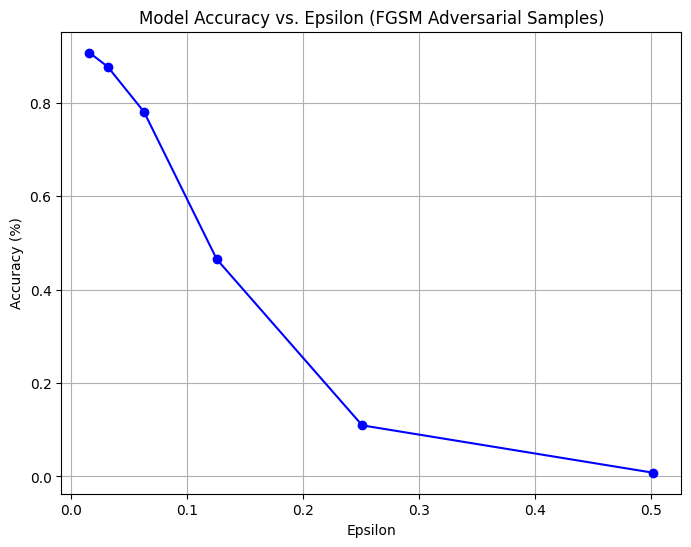

[0.9069, 0.8771, 0.7803, 0.4649, 0.1093, 0.0079]

In [159]:
#Your code goes here.
FGSM_attack(model, new_model, epsilons, testloader)

## Effect of the number of initial samples on the attack's success rate

For 10, 100, and 150 as the number of initial samples, assess the success rate of your attacks for different $\epsilon$'s.  

`answer`:As demonstrated in the plots of accuracy versus $\epsilon$, an increase in the number of initial samples leads to an enhancement in both the test accuracy and the success rate of the Fast Gradient Sign Method (FGSM) attack. This suggests that the quantity of initial samples plays a crucial role in the effectiveness of the FGSM attack, with a larger sample size contributing to a higher success rate.


Number of Initial Samples: 10####################################################################
round: 0-----------------------------------------------------------------------------
Epoch 1:
Train Loss: 2.3118233680725098, Train Accuracy: 10.0%
Test accuracy at epoch 1: 9.71


Epoch 2:
Train Loss: 2.2813007831573486, Train Accuracy: 20.0%
Test accuracy at epoch 2: 9.8


Epoch 3:
Train Loss: 2.1750876903533936, Train Accuracy: 20.0%
Test accuracy at epoch 3: 9.8


Epoch 4:
Train Loss: 2.150782585144043, Train Accuracy: 20.0%
Test accuracy at epoch 4: 9.8


Epoch 5:
Train Loss: 2.0409622192382812, Train Accuracy: 30.0%
Test accuracy at epoch 5: 9.8


Epoch 6:
Train Loss: 2.048915147781372, Train Accuracy: 20.0%
Test accuracy at epoch 6: 9.8


Epoch 7:
Train Loss: 2.3203182220458984, Train Accuracy: 20.0%
Test accuracy at epoch 7: 9.8


Epoch 8:
Train Loss: 1.910146713256836, Train Accuracy: 30.0%
Test accuracy at epoch 8: 9.8


Epoch 9:
Train Loss: 1.8441860675811768, Train Accuracy: 4

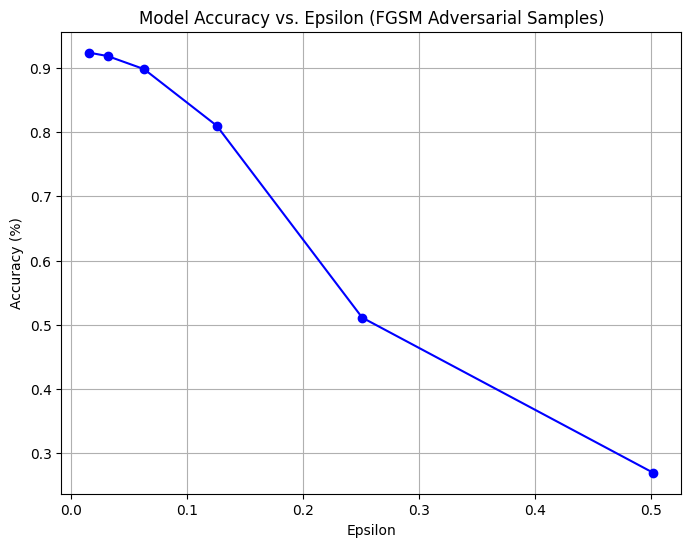






Number of Initial Samples: 100####################################################################
round: 0-----------------------------------------------------------------------------
Epoch 1:
Train Loss: 2.323310375213623, Train Accuracy: 7.000000000000001%
Test accuracy at epoch 1: 11.74


Epoch 2:
Train Loss: 2.2873849868774414, Train Accuracy: 11.0%
Test accuracy at epoch 2: 10.34


Epoch 3:
Train Loss: 2.252850294113159, Train Accuracy: 19.0%
Test accuracy at epoch 3: 14.499999999999998


Epoch 4:
Train Loss: 2.190803050994873, Train Accuracy: 23.0%
Test accuracy at epoch 4: 26.1


Epoch 5:
Train Loss: 2.181119441986084, Train Accuracy: 24.0%
Test accuracy at epoch 5: 38.75


Epoch 6:
Train Loss: 2.123675584793091, Train Accuracy: 30.0%
Test accuracy at epoch 6: 42.809999999999995


Epoch 7:
Train Loss: 2.016613483428955, Train Accuracy: 38.0%
Test accuracy at epoch 7: 50.71


Epoch 8:
Train Loss: 1.9539140462875366, Train Accuracy: 46.0%
Test accuracy at epoch 8: 54.25


Ep

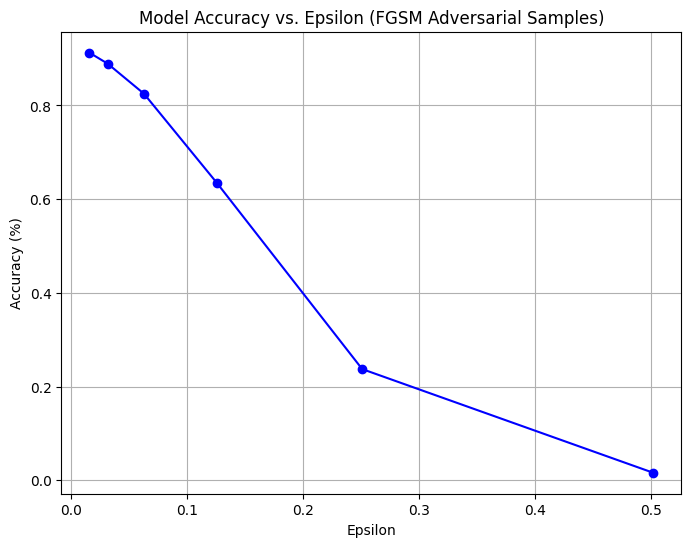






Number of Initial Samples: 150####################################################################
round: 0-----------------------------------------------------------------------------
Epoch 1:
Train Loss: 2.319936156272888, Train Accuracy: 6.666666666666667%
Test accuracy at epoch 1: 10.280000000000001


Epoch 2:
Train Loss: 2.2656362056732178, Train Accuracy: 16.0%
Test accuracy at epoch 2: 10.280000000000001


Epoch 3:
Train Loss: 2.2012147903442383, Train Accuracy: 16.0%
Test accuracy at epoch 3: 11.23


Epoch 4:
Train Loss: 2.1672927141189575, Train Accuracy: 20.666666666666668%
Test accuracy at epoch 4: 17.669999999999998


Epoch 5:
Train Loss: 2.162026286125183, Train Accuracy: 22.0%
Test accuracy at epoch 5: 25.419999999999998


Epoch 6:
Train Loss: 2.0374311208724976, Train Accuracy: 29.333333333333332%
Test accuracy at epoch 6: 32.98


Epoch 7:
Train Loss: 1.9335349202156067, Train Accuracy: 29.333333333333332%
Test accuracy at epoch 7: 39.269999999999996


Epoch 8:
Trai

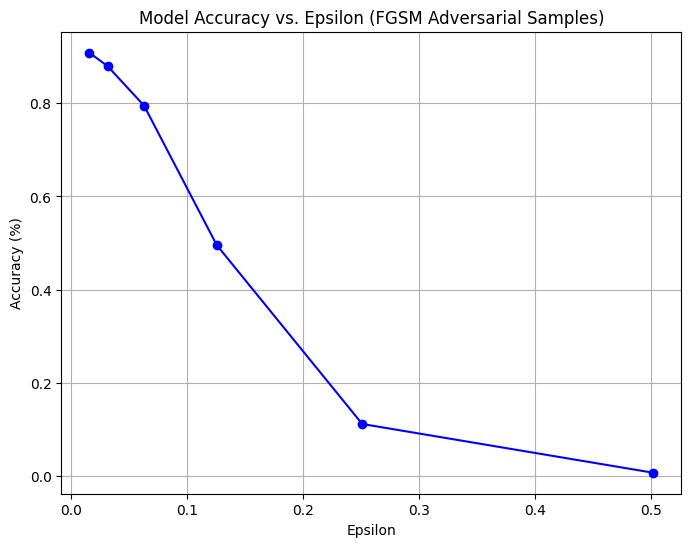

In [151]:
#Your code goes here

num_initial_samples = [10, 100, 150]

for num_sample in num_initial_samples:
    print(f'Number of Initial Samples: {num_sample} ####################################################################')
    # Preparing initial dataset
    initial_inputs, initial_targets = select_random_samples(testset, num_sample=num_sample)
    initial_trainset = AugmentedMNIST(inputs=initial_inputs, targets=initial_targets,
                                      transform=testset.transform)
    initial_trainloader = DataLoader(initial_trainset, batch_size=batch_size, shuffle=True)
    # setting hyperparameters and training the substitute model
    epochs = 15
    rounds = 5
    update_coef = 0.1
    model.to(device)
    new_model, _, _ = train_jacobian(model, initial_trainloader, epochs = epochs, rounds = rounds, update_coef = update_coef)
    print(f'FGSM attack results with {num_sample} initial samples')
    FGSM_attack(model, new_model, epsilons, testloader)
    print('\n\n\n\n')
